## Self Driving Car NanoDegree

### Advanced Lane Finding

### Calibrating Camera and Undistortion

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import glob


In [2]:
# Read in calibration image
images = glob.glob('./camera_cal/calibration*.jpg') # reads in RGB

In [3]:
# Take distorted img and return undistorted version
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
# Arrays to store object points and image points from all the images
objpoints = []
imgpoints = [] 

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for file in images:
    
    # Read in image
    img = mpimg.imread(file)
    
    # Convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # if corners found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow()

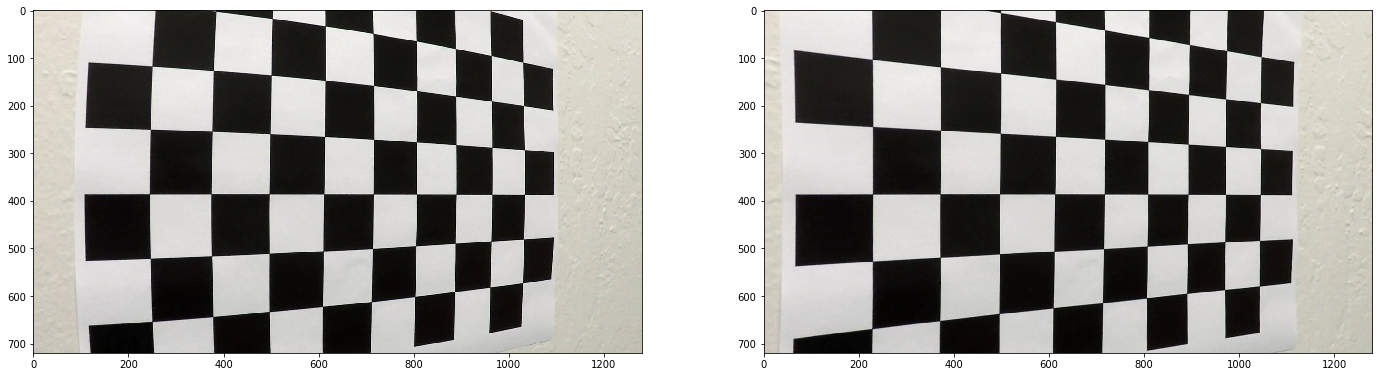

In [5]:
img = mpimg.imread(images[0])
dst = undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(dst)
# cv2.imwrite( "./output_images/chessboard_distorted.png", img )
# cv2.imwrite( "./output_images/chessboard_ungdistorted.png", dst )

#### Region of Interest

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

True

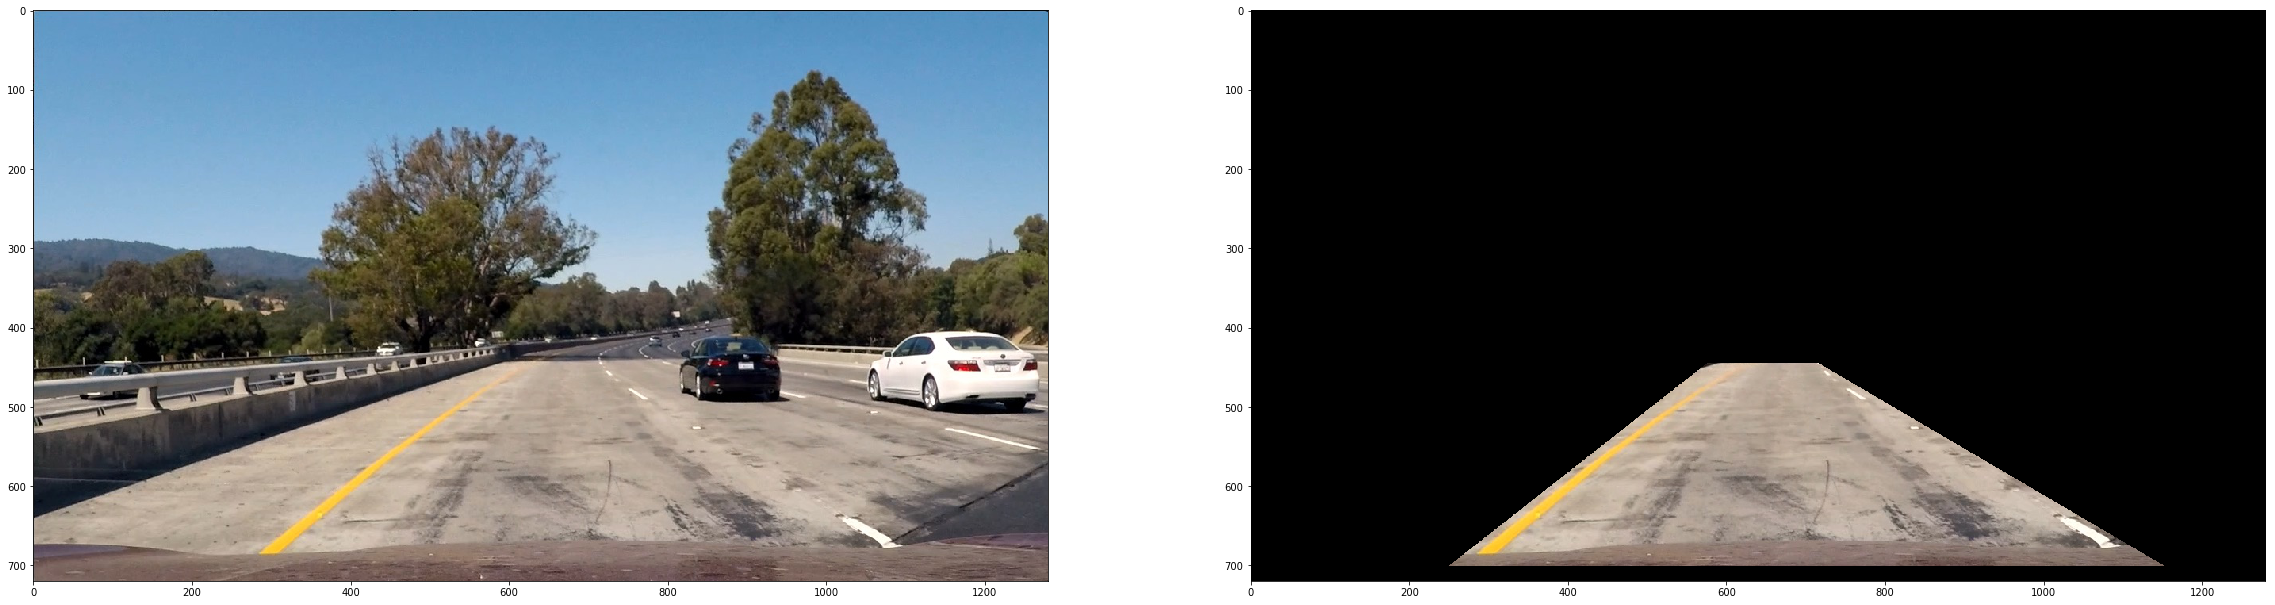

In [25]:
img = mpimg.imread('./test_images/test1.jpg')
vertices = np.array([[(250,700),(1150, 700), (715, 445), (575, 445)]], dtype=np.int32) 

region = region_of_interest(img, vertices)
# Plot image progression
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(region)
cv2.imwrite( "./output_images/no_region.png",  cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
cv2.imwrite( "./output_images/region.png", cv2.cvtColor(region, cv2.COLOR_RGB2BGR) )

#### Threshold 

In [8]:
def color_thresh(img, vertices):
    
    # Mask with region of interest
    img = region_of_interest(img, vertices)
    
    #  RGB Yellow thresholding
    lower_yellow = np.array([190,190,0], dtype = "uint8")
    upper_yellow = np.array([255,255,150], dtype = "uint8")
    mask = cv2.inRange(img, lower_yellow, upper_yellow)
    mask_yellow = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    yellow_img = img & mask_yellow
    yellow_binary = cv2.cvtColor(yellow_img, cv2.COLOR_RGB2GRAY)
    
    
    # RGB White
    lower_white = np.array([195,200,200], dtype = "uint8")
    upper_white = np.array([255,255,255], dtype = "uint8")
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_white = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    white_img = img & mask_white
    white_binary = cv2.cvtColor(white_img, cv2.COLOR_RGB2GRAY)
    

    
    # HSV White
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower_white_hsv = np.array([0,150,100], dtype = "uint8")
    upper_white_hsv = np.array([100,255,255], dtype = "uint8")
    mask = cv2.inRange(hsv, lower_white_hsv, upper_white_hsv)
    mask_white_hsv = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_white_hsv = cv2.cvtColor(mask_white_hsv, cv2.COLOR_RGB2HSV)
    white_img_hsv = hsv & mask_white_hsv
    white_img_hsv_binary = cv2.cvtColor(white_img_hsv, cv2.COLOR_HSV2RGB)
    white_img_hsv_binary = cv2.cvtColor(white_img_hsv, cv2.COLOR_RGB2GRAY)

    result = np.zeros_like(white_img_hsv_binary)
    result = yellow_binary | white_img_hsv_binary | white_binary
    
    return result

True

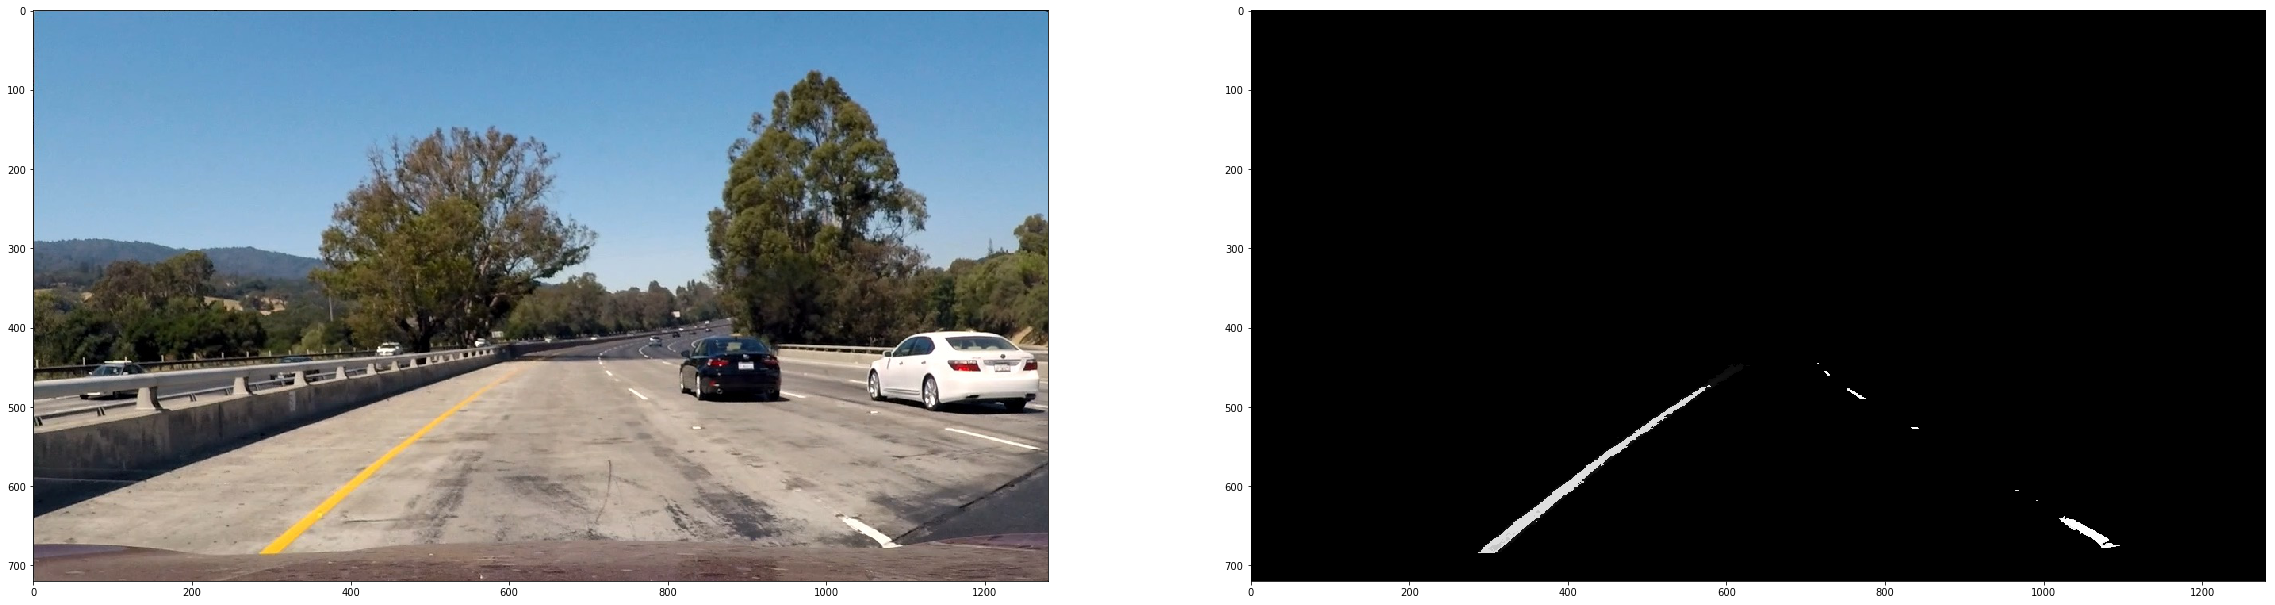

In [9]:
img = mpimg.imread('./test_images/test1.jpg')
out = color_thresh(img, vertices)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(out, cmap='gray')
cv2.imwrite( "./output_images/unmasked.png",  cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
cv2.imwrite( "./output_images/masked.png", out )
#plt.imshow(result)

#### Perspective Transform 

In [10]:
def warp(img):
    
    # Define calibration box and destination box
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinate points
    src = np.float32(
        [[300, 650], # bottom left
         [1000, 650], # bottom right
         [600, 447], # top left
         [680, 447]]) # top right
    
    dst = np.float32(
        [[375, 720],
         [1000, 720],
         [375, 0],
         [1000, 0]])
     
    # Compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image, use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv



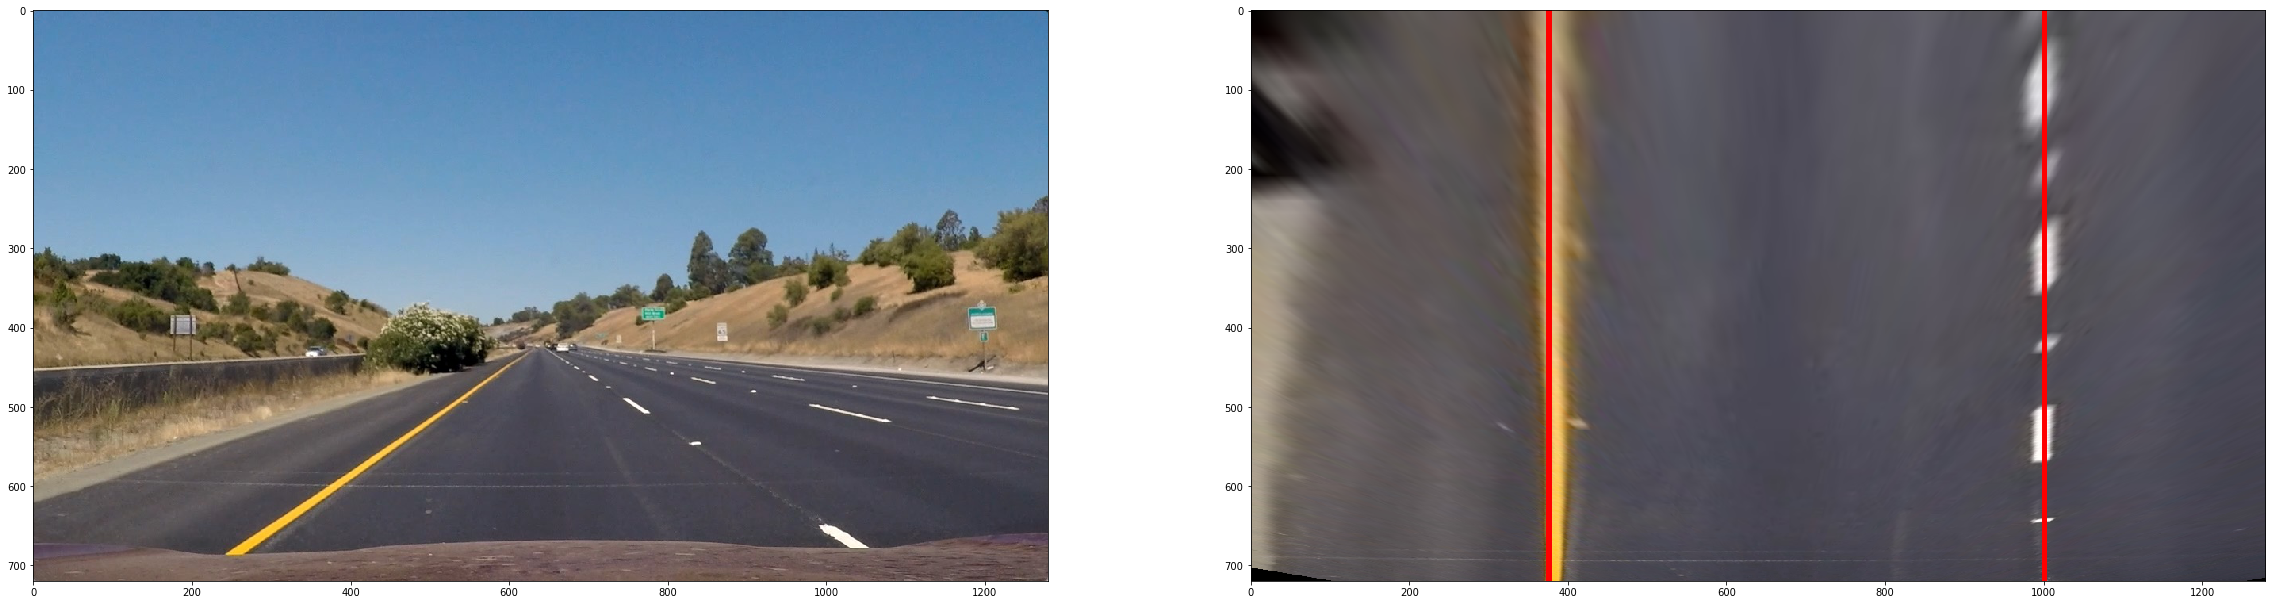

In [11]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/test1.jpg')

# for drawing 
# cv2.line(img,(300,650),(600,447),(255,0,0),5)
# cv2.line(img,(1000,650),(690,447),(255,0,0),5)

# undistort image
undist = undistort(img, objpoints, imgpoints)

# color thresh (yellow and white)
combined_binary = color_thresh(undist, vertices)

# perspective transform (bird's eye view)
binary_warped, M, Minv = warp(img)

# for drawing
cv2.line(binary_warped,(375,720),(375,0),(255,0,0),5)
cv2.line(binary_warped,(1000,720),(1000,0),(255,0,0),5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(binary_warped)

# for saving
#cv2.imwrite( "./output_images/before_perspective.png",  cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
#cv2.imwrite( "./output_images/after_perspective.png", cv2.cvtColor(binary_warped, cv2.COLOR_RGB2BGR))



#### Sliding Window Search

In [12]:
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    return out_img, left_fit, right_fit

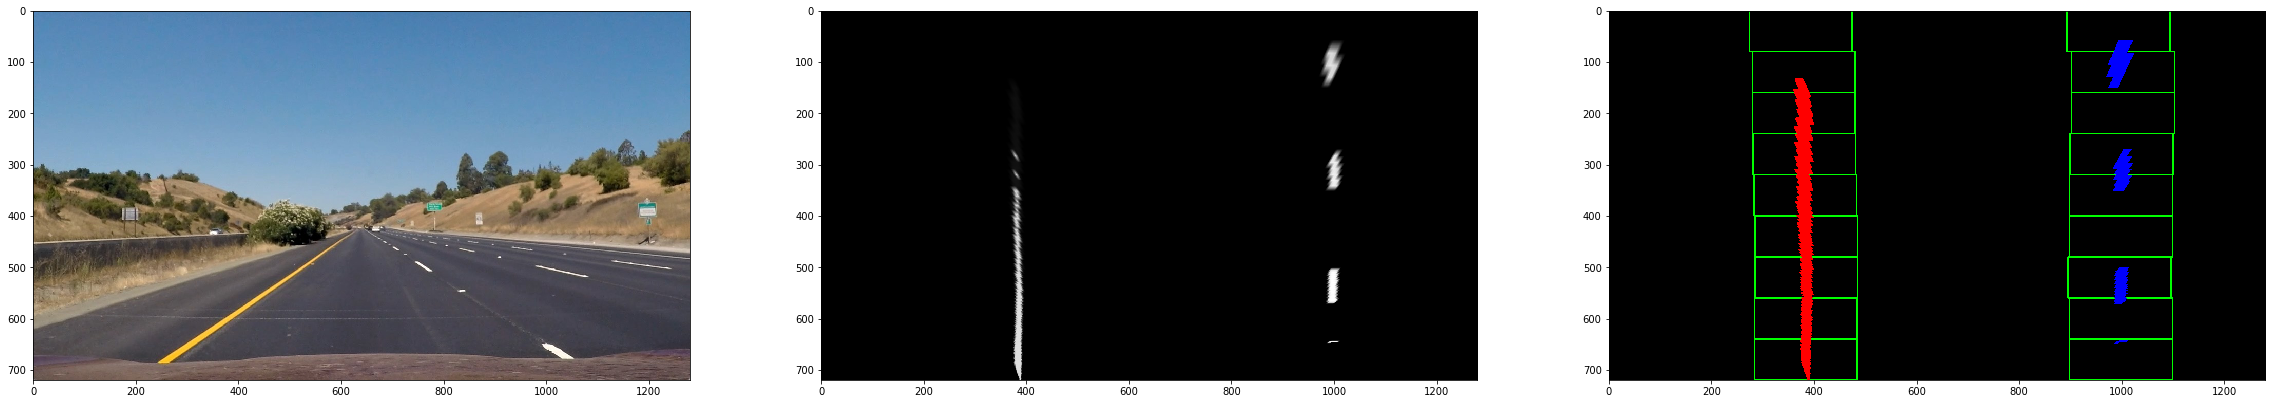

In [13]:
img = mpimg.imread('./test_images/straight_lines1.jpg')

# undistort image
undist = undistort(img, objpoints, imgpoints)
    
# binary mask 
result = color_thresh(undist, vertices)

# perspective transform (bird's eye view)
binary_warped, M, Minv = warp(result)

# sliding window
windowed, left_fit, right_fit = sliding_window(binary_warped)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(binary_warped, cmap='gray')
ax3.imshow(windowed)
# cv2.imwrite( "./output_images/sliding0.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
# cv2.imwrite( "./output_images/sliding2.png", binary_warped )
# # cv2.imwrite( "./output_images/sliding3.png", windowed )



In [14]:
#### Add Curvature Data

In [15]:
def add_curvature_data(img, radius, center_dist):
    
    img_copy = np.copy(img)
    
    # Curvature
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(radius) + ' meters'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_copy,text,(20,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)

    # Dist from Center
    abs_center_dist = abs(center_dist)
    text = 'Distance from Center: {:04.3f}'.format(abs_center_dist) + ' meters'
    cv2.putText(img_copy, text, (20,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    
    return img_copy

## Pipeline

In [16]:

def pipeline(img):

    # undistort image
    undist = undistort(img, objpoints, imgpoints)
    
    #region of interest mask
    vertices = np.array([[(250,700),(1150, 700), (715, 430), (575, 430)]], dtype=np.int32) 
#     region = region_of_interest(undist, vertices)
    
    # color thresh (yellow and white)
    combined_binary = color_thresh(undist, vertices )
    
    # perspective transform (bird's eye view)
    binary_warped, M, Minv = warp(combined_binary)
    
    # sliding window search
    out_img, left_fit, right_fit = sliding_window(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


    # Define conversion from pixels to meters, assume the lane is 3.7 meters wide 30 meters tall
    y_eval = 720
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimesion
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
     
    # Find the position of the car from the center
    img_center = 1280/2
    center = (left_fitx[0] + right_fitx[0])/2
    
    # Define conversion from pixels to meters, assume the lane is 3.7 meters wide
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    position = (img_center - center)*xm_per_pix
   
    # Add curvature and distance from center to img
    result = add_curvature_data(result, left_curverad, position)
    
    
    
    return result

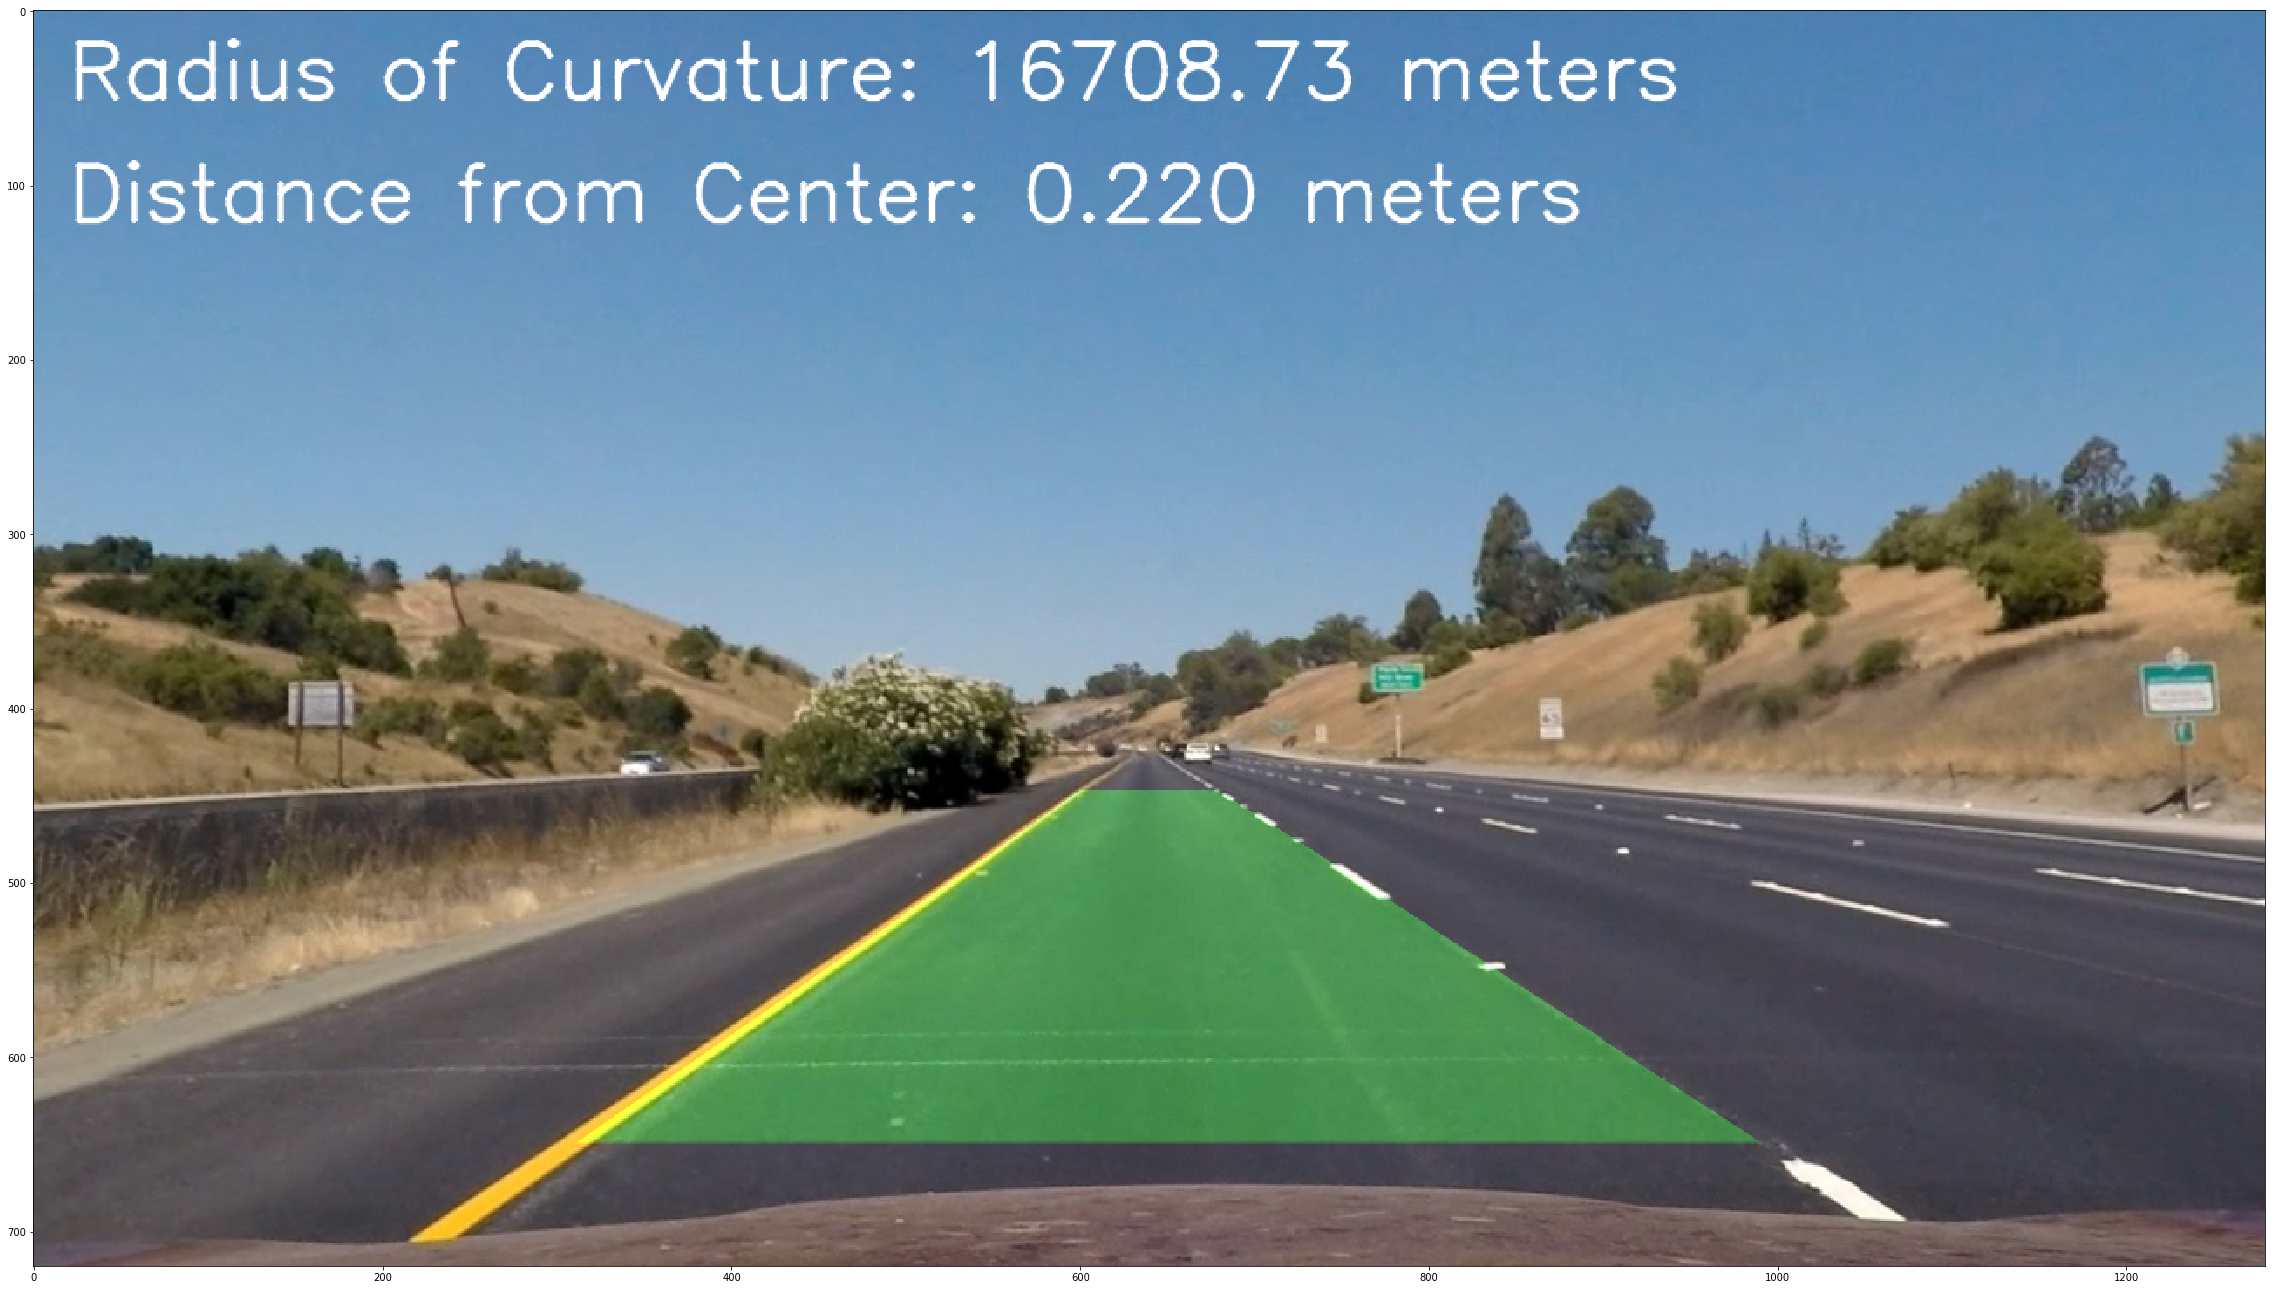

In [17]:
img = mpimg.imread('./test_images/straight_lines1.jpg') 
result = pipeline(img)

f, (ax1) = plt.subplots(1, 1, figsize=(40,40))
ax1.imshow(result)
#

## Video

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)#NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output_better3.mp4
[MoviePy] Writing video project_video_output_better3.mp4


100%|█████████▉| 1260/1261 [16:15<00:00,  1.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_better3.mp4 

CPU times: user 17min 14s, sys: 31.3 s, total: 17min 46s
Wall time: 16min 16s


In [29]:
project_output = 'project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))